<a href="https://colab.research.google.com/github/JulianEspinosaUrresti/ProyectoI-MIAA-2025/blob/main/Taller_2_AAIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Carga de Paquetes***

In [458]:
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

### **2. Carga de Datos**

In [459]:
data = pd.read_excel("https://raw.githubusercontent.com/profedaniel86/Series_de_Tiempo/refs/heads/main/1.Intro/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


(222, 4)


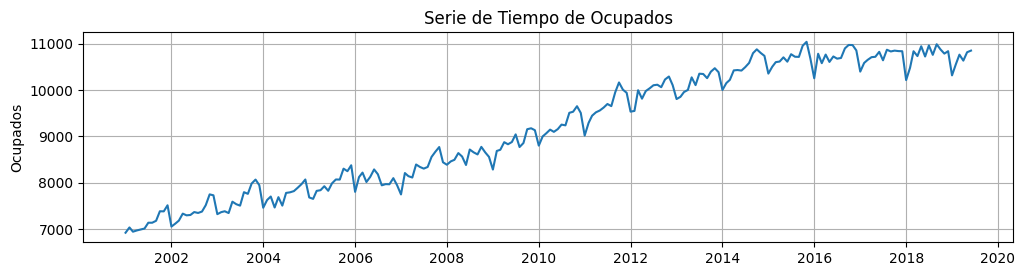

In [460]:
print(data.shape)

fig = plt.figure(figsize=(12, 6))

plt.subplot(2,1, 1)
plt.title("Serie de Tiempo de Ocupados")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()

plt.show()

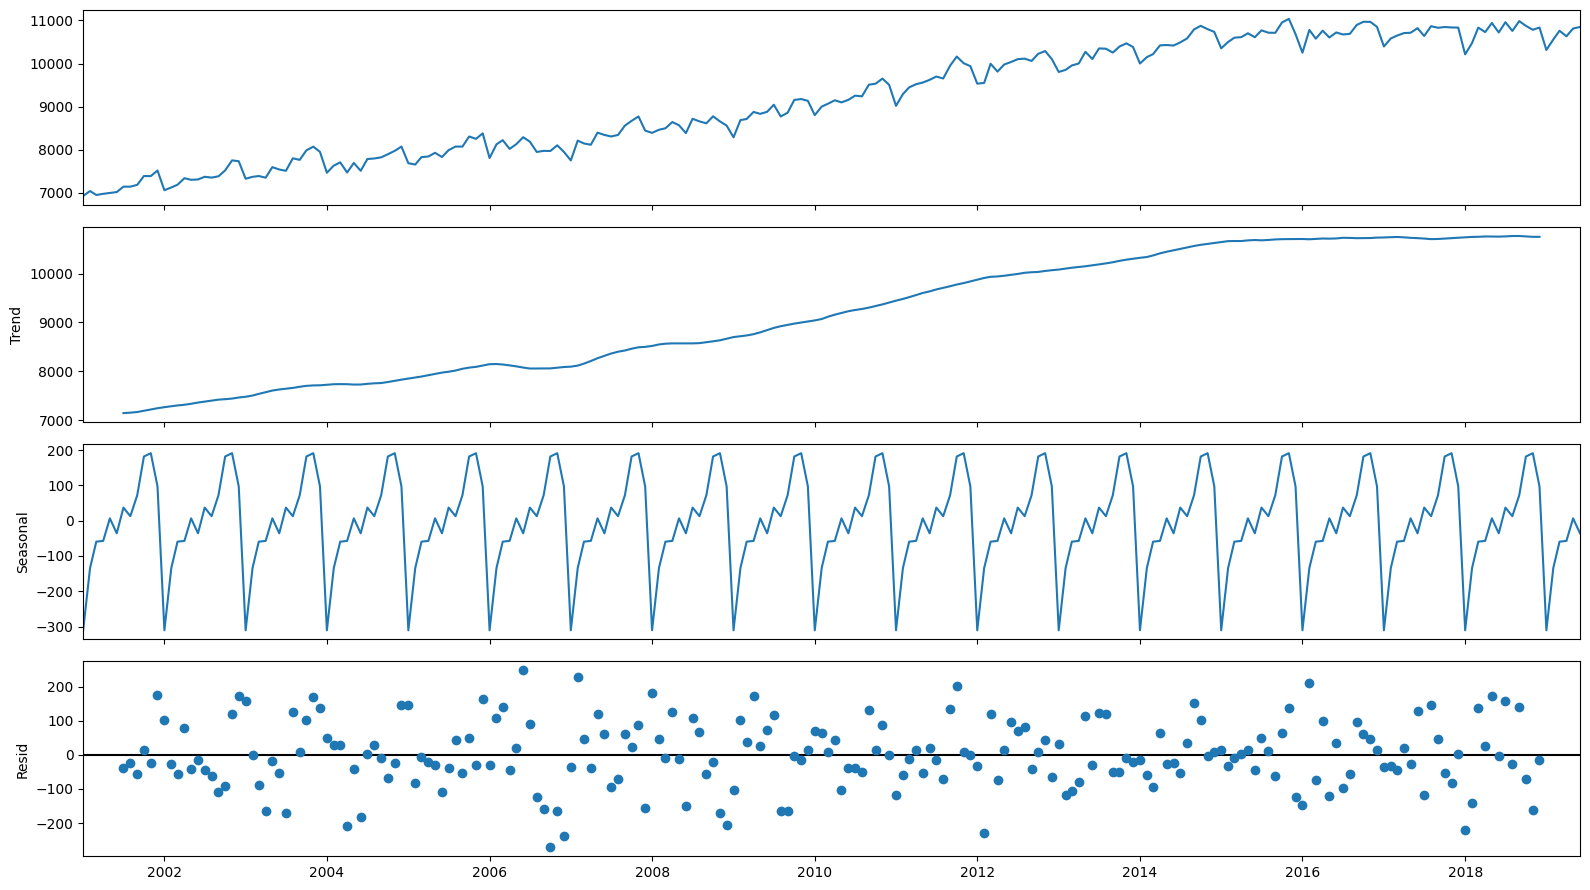

In [461]:
td_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

### **3. Autocorrelación**

Para determinar si existe autocorrelación usamos la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Las hipótesis son las siguientes:

H0:ρ=0  (Es decir no hay autocorrelación)

H1:ρ≠0  (Es decir hay autocorrelación)

Rechazo  H0  cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un  α =0.05 ( α  = nivel de significancia).

In [462]:
signo = data.Ocupados>0

In [463]:
signo.value_counts()

,count
Ocupados,
True,222


In [464]:
runstest_1samp(signo, correction=False)

/usr/local/lib/python3.12/dist-packages/statsmodels/sandbox/stats/runs.py:102: RuntimeWarning: invalid value encountered in scalar divide
  z /= rstd


(np.float64(nan), np.float64(nan))

In [465]:
# prueba de Box-Pierce y la modificación de Ljung-Box
sm.stats.acorr_ljungbox(data.Ocupados, lags=[1], return_df=True,boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,215.466151,8.818153e-49,212.580444,3.757527e-48


Hay autocorrelación para el primer rezago.




In [466]:
Resul_lb_bp = sm.stats.acorr_ljungbox(data.Ocupados, lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,215.466151,8.818153e-49,212.580444,3.757527e-48,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,425.045838,5.040446e-93,418.417636,1.386005e-91,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,629.973395,3.201138e-136,618.770917,8.590288e-134,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,830.534686,1.866623e-178,813.960031,7.268819e-175,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,1028.006530,5.191558e-220,1005.260880,4.364213e-215,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,1222.035167,8.145806e-261,1192.359923,2.155332e-254,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,1412.841689,6.426069e-301,1375.500111,7.718370e-293,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,1599.512253,0.000000e+00,1553.837168,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,1782.749605,0.000000e+00,1728.076257,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,1963.258217,0.000000e+00,1898.914764,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


En el anterior data frame las columnas lb_ho y bp_ho nos permiten entender la decisión a tomar al usar las dos pruebas. Se puede concluir que la Si presenta autocorrelación.

### **4. Tendencia Lineal**

In [467]:
y = data["Ocupados"]
x = np.linspace(1,data.shape[0],data.shape[0])
X = sm.add_constant(x)
lin = sm.OLS(y,X)
lin_t = lin.fit()
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     4729.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          1.02e-150
Time:                        02:59:07   Log-Likelihood:                -1559.9
No. Observations:                 222   AIC:                             3124.
Df Residuals:                     220   BIC:                             3131.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6962.4958     36.871    188.835      0.0

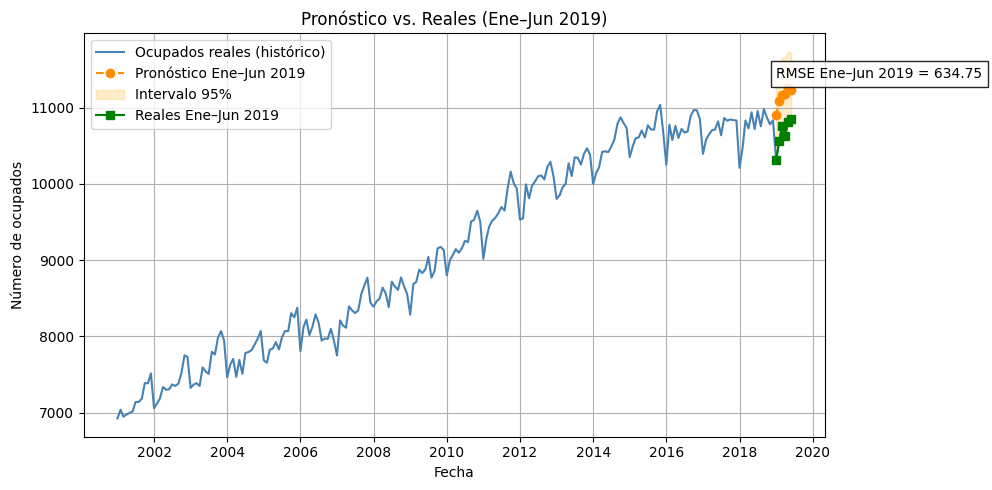

RMSE Ene–Jun 2019 = 634.75


In [468]:
h = len(preds)
target_idx = pd.date_range('2019-01-01', periods=h, freq='MS')
preds = preds.copy()
preds.index = target_idx

y_real_6 = data.loc['2019-01':'2019-06', 'Ocupados']
y_pred_6 = preds.loc['2019-01':'2019-06', 'Point_forecast']

plt.figure(figsize=(10,5))
plt.plot(data.index, data['Ocupados'], label='Ocupados reales (histórico)', color='steelblue')
plt.plot(preds.index, preds['Point_forecast'], '--o', color='darkorange', label='Pronóstico Ene–Jun 2019')

if {'lower_95','upper_95'}.issubset(preds.columns):
    plt.fill_between(preds.index, preds['lower_95'], preds['upper_95'], alpha=0.2, color='orange', label='Intervalo 95%')

plt.plot(y_real_6.index, y_real_6.values, 'gs-', label='Reales Ene–Jun 2019')

y_top = max(data['Ocupados'].max(), getattr(preds['upper_95'], 'max', preds['Point_forecast'].max)())
plt.text(preds.index[0], y_top*0.97, f"RMSE Ene–Jun 2019 = {rmse_6:.2f}",
         bbox=dict(facecolor='white', alpha=0.85))

plt.title('Pronóstico vs. Reales (Ene–Jun 2019)')
plt.xlabel('Fecha'); plt.ylabel('Número de ocupados')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
print(f"RMSE Ene–Jun 2019 = {rmse_6:.2f}")

                Real  Predicho   Error  |Error|  % Error
2019-01-01  10314.44  10899.31 -584.87   584.87    -5.67
2019-02-01  10557.92  11087.81 -529.89   529.89    -5.02
2019-03-01  10760.78  11172.49 -411.71   411.71    -3.83
2019-04-01  10632.03  11180.78 -548.75   548.75    -5.16
2019-05-01  10813.00  11259.31 -446.31   446.31    -4.13
2019-06-01  10848.00  11234.76 -386.76   386.76    -3.57


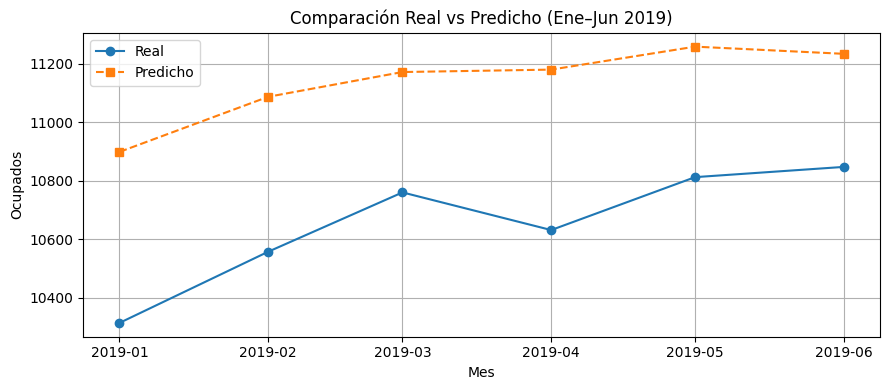

In [469]:
target_idx = pd.date_range('2019-01-01', periods=6, freq='MS')

y_real = data.loc[target_idx, 'Ocupados']
y_pred = preds.loc[target_idx, 'Point_forecast']

cmp = pd.DataFrame({
    'Real': y_real,
    'Predicho': y_pred
}, index=common)

cmp['Error'] = cmp['Real'] - cmp['Predicho']
cmp['|Error|'] = cmp['Error'].abs()
cmp['% Error'] = 100 * cmp['Error'] / cmp['Real']

print(cmp.round(2))

plt.figure(figsize=(9,4))
plt.plot(cmp.index, cmp['Real'], marker='o', label='Real')
plt.plot(cmp.index, cmp['Predicho'], marker='s', linestyle='--', label='Predicho')
plt.title('Comparación Real vs Predicho (Ene–Jun 2019)')
plt.xlabel('Mes'); plt.ylabel('Ocupados'); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

### **5. Tendencia Cuadratica**

In [470]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = x**2
X = sm.add_constant(data[["x","x2"]])
pol = sm.OLS(y,X)
pol_2 = pol.fit()
print(pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     2560.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          1.33e-152
Time:                        02:59:08   Log-Likelihood:                -1551.0
No. Observations:                 222   AIC:                             3108.
Df Residuals:                     219   BIC:                             3118.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6790.8804     53.552    126.810      0.0

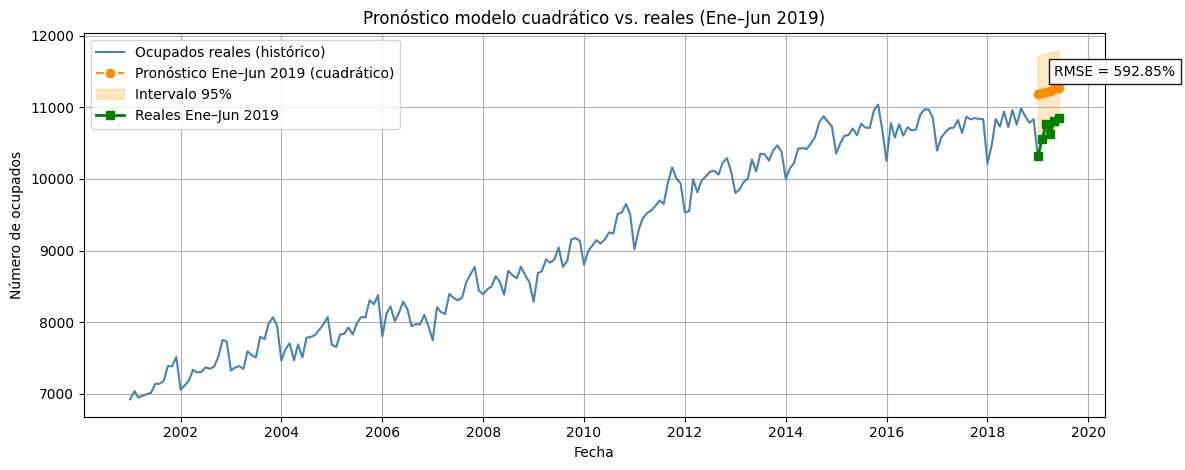


RMSE (cuadrático): 592.85


In [471]:
h = 6
x_for = np.linspace(data.shape[0] + 1, data.shape[0] + h, h)
x_for_quad = np.column_stack((x_for, x_for**2))
X_for = sm.add_constant(x_for_quad)

dt_q = pol_2.get_prediction(X_for).summary_frame(alpha=0.05)

preds_q = dt_q[['mean', 'obs_ci_lower', 'obs_ci_upper']].copy()
preds_q.columns = ['Point_forecast', 'lower_95', 'upper_95']

target_idx = pd.date_range('2019-01-01', periods=6, freq='MS')
preds_q.index = target_idx

y_real_6 = data.loc['2019-01':'2019-06', 'Ocupados']
y_pred_6 = preds_q.loc['2019-01':'2019-06', 'Point_forecast']

common = y_real_6.index.intersection(y_pred_6.index)
y_real_6 = y_real_6.loc[common]
y_pred_6 = y_pred_6.loc[common]

rmse_q = np.sqrt(mean_squared_error(y_real_6, y_pred_6))
mape_q = (np.abs((y_real_6 - y_pred_6) / y_real_6).mean()) * 100

plt.figure(figsize=(12,4.8))

plt.plot(data.index, data['Ocupados'],
         color='steelblue', label='Ocupados reales (histórico)')

plt.plot(preds_q.index, preds_q['Point_forecast'],
         '--o', color='darkorange', label='Pronóstico Ene–Jun 2019 (cuadrático)')

plt.fill_between(preds_q.index, preds_q['lower_95'], preds_q['upper_95'],
                 color='orange', alpha=0.25, label='Intervalo 95%')

plt.plot(y_real_6.index, y_real_6.values,
         'gs-', linewidth=2, label='Reales Ene–Jun 2019')

y_top = max(data['Ocupados'].max(), preds_q['upper_95'].max())
plt.text(preds_q.index[-2], y_top*0.97,
         f"RMSE = {rmse_q:.2f}%",
         fontsize=10, bbox=dict(facecolor='white', alpha=0.9))

plt.title('Pronóstico modelo cuadrático vs. reales (Ene–Jun 2019)')
plt.xlabel('Fecha'); plt.ylabel('Número de ocupados')
plt.legend(loc='upper left'); plt.grid(True); plt.tight_layout()
plt.show()

cmp_q['Error']   = cmp_q['Real'] - cmp_q['Predicho']
cmp_q['|Error|'] = cmp_q['Error'].abs()
cmp_q['% Error'] = 100 * cmp_q['Error'] / cmp_q['Real']
print(f"\nRMSE (cuadrático): {rmse_q:.2f}")

                Real  Predicho   Error  |Error|  % Error
2019-01-01  10314.44  11187.59 -873.15   873.15    -8.47
2019-02-01  10557.92  11202.69 -644.77   644.77    -6.11
2019-03-01  10760.78  11217.75 -456.97   456.97    -4.25
2019-04-01  10632.03  11232.77 -600.74   600.74    -5.65
2019-05-01  10813.00  11247.74 -434.74   434.74    -4.02
2019-06-01  10848.00  11262.67 -414.67   414.67    -3.82


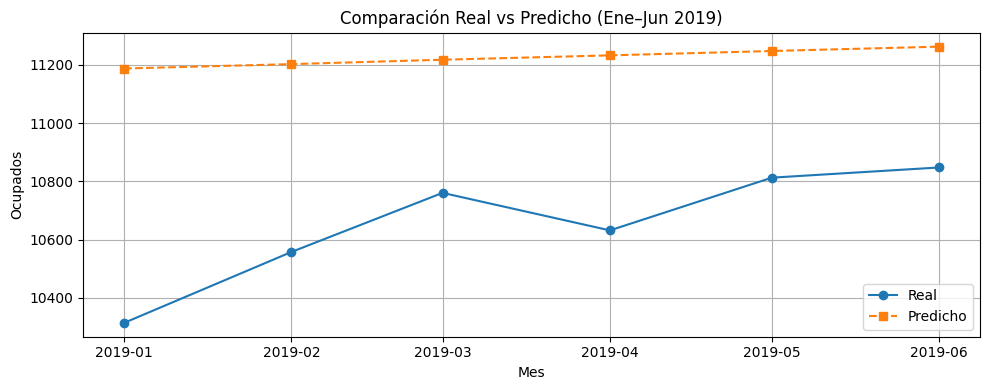

In [472]:
target_idx = pd.date_range('2019-01-01', periods=6, freq='MS')

y_real = data.loc[target_idx, 'Ocupados']
y_pred = preds_q.loc[target_idx, 'Point_forecast']

cmp_q = pd.DataFrame({
    'Real': y_real,
    'Predicho': y_pred
}, index=common)

cmp_q['Error'] = cmp_q['Real'] - cmp_q['Predicho']
cmp_q['|Error|'] = cmp_q['Error'].abs()
cmp_q['% Error'] = 100 * cmp_q['Error'] / cmp_q['Real']

# Mostrar tabla
print(cmp_q.round(2))

plt.figure(figsize=(10,4))
plt.plot(cmp_q.index, cmp_q['Real'], marker='o', label='Real')
plt.plot(cmp_q.index, cmp_q['Predicho'], marker='s', linestyle='--', label='Predicho')
plt.title('Comparación Real vs Predicho (Ene–Jun 2019)')
plt.xlabel('Mes'); plt.ylabel('Ocupados')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

### **6. Estacionalidad**

In [473]:
month_dummies = pd.get_dummies(data.index.month,drop_first=True, dtype=float).set_index(data.index)

y = data["Ocupados"]
X = sm.add_constant(month_dummies)
sea = sm.OLS(y,X)
season = sea.fit()
print(season.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.2687
Date:                Sun, 09 Nov 2025   Prob (F-statistic):              0.991
Time:                        02:59:09   Log-Likelihood:                -1903.9
No. Observations:                 222   AIC:                             3832.
Df Residuals:                     210   BIC:                             3873.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8808.2176    302.768     29.092      0.0

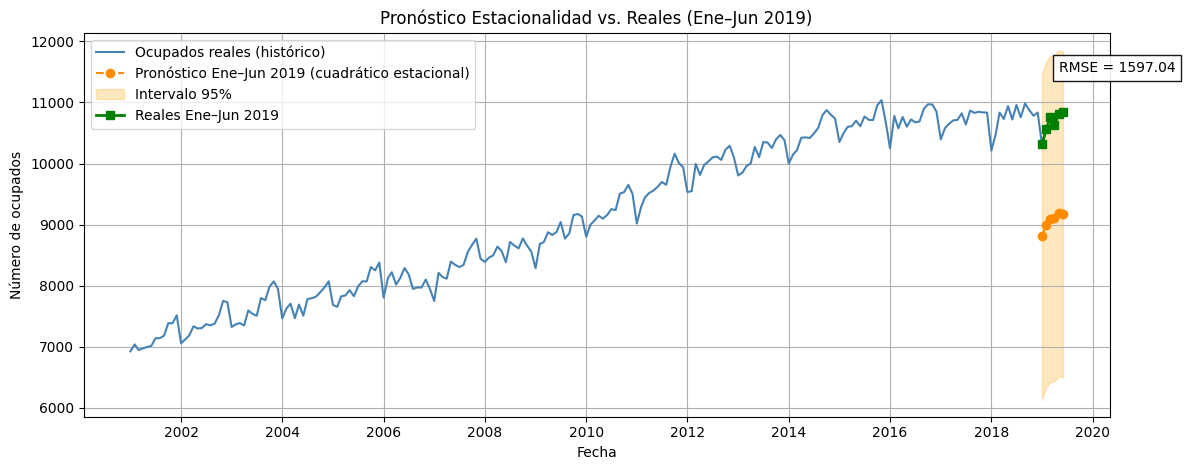

RMSE (Estacionalidad, Ene–Jun 2019): 1597.04


In [474]:
future_idx = pd.date_range('2019-01-01', periods=6, freq='MS')

train_cols = month_dummies.columns  # dummies 2..12 (porque drop_first=True)
future_dummies = pd.DataFrame(0, index=future_idx, columns=train_cols, dtype=float)
for dt in future_idx:
    m = dt.month
    if m in train_cols:
        future_dummies.loc[dt, m] = 1.0

X_for_season = sm.add_constant(future_dummies, has_constant='add')
X_for_season = X_for_season[season.model.exog_names]  # mismo orden de columnas

pred_sf = season.get_prediction(X_for_season).summary_frame(alpha=0.05)
preds_s = pred_sf[['mean', 'obs_ci_lower', 'obs_ci_upper']].rename(
    columns={'mean':'Point_forecast','obs_ci_lower':'lower_95','obs_ci_upper':'upper_95'}
)
preds_s.index = future_idx

y_real_6 = data.loc['2019-01':'2019-06', 'Ocupados']
y_pred_6 = preds_s.loc['2019-01':'2019-06', 'Point_forecast']

rmse_season = np.sqrt(mean_squared_error(y_real_6, y_pred_6))

plt.figure(figsize=(12,4.8))

plt.plot(data.index, data['Ocupados'], color='steelblue', label='Ocupados reales (histórico)')

plt.plot(preds_s.index, preds_s['Point_forecast'], '--o', color='darkorange',
         label='Pronóstico Ene–Jun 2019 (cuadrático estacional)')  # etiqueta libre; ajusta si prefieres

plt.fill_between(preds_s.index, preds_s['lower_95'], preds_s['upper_95'],
                 color='orange', alpha=0.25, label='Intervalo 95%')

plt.plot(y_real_6.index, y_real_6.values, 'gs-', linewidth=2, label='Reales Ene–Jun 2019')

y_top = max(data['Ocupados'].max(), preds_s['upper_95'].max())
plt.text(preds_s.index[-2], y_top*0.97, f"RMSE = {rmse_season:.2f}",
         fontsize=10, bbox=dict(facecolor='white', alpha=0.9))

plt.title('Pronóstico Estacionalidad vs. Reales (Ene–Jun 2019)')
plt.xlabel('Fecha'); plt.ylabel('Número de ocupados')
plt.legend(loc='upper left'); plt.grid(True); plt.tight_layout()
plt.show()
print(f"RMSE (Estacionalidad, Ene–Jun 2019): {rmse_season:.2f}")

                Real  Predicho    Error  |Error|  % Error
2019-01-01  10314.44   8808.22  1506.22  1506.22    14.60
2019-02-01  10557.92   9001.04  1556.88  1556.88    14.75
2019-03-01  10760.78   9090.04  1670.74  1670.74    15.53
2019-04-01  10632.03   9102.65  1529.38  1529.38    14.38
2019-05-01  10813.00   9185.51  1627.49  1627.49    15.05
2019-06-01  10848.00   9165.27  1682.73  1682.73    15.51


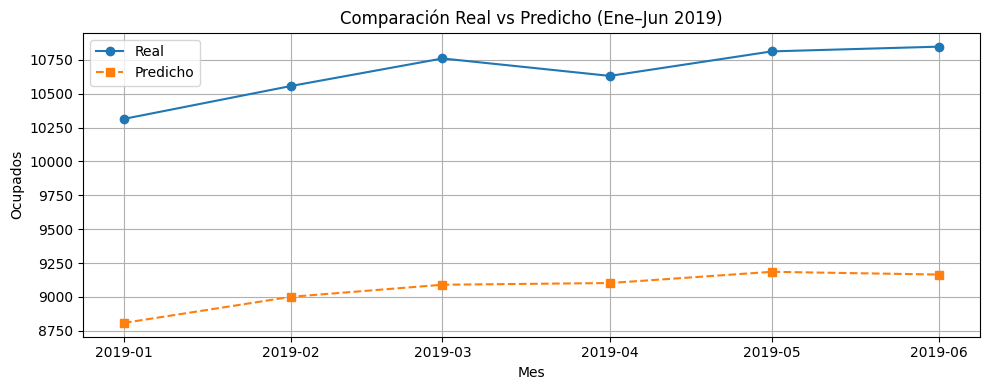

In [475]:
target_idx = pd.date_range('2019-01-01', periods=6, freq='MS')

y_real = data.loc[target_idx, 'Ocupados']
y_pred = preds_s.loc[target_idx, 'Point_forecast']

cmp_s = pd.DataFrame({
    'Real': y_real,
    'Predicho': y_pred
}, index=common)
cmp_s['Error']   = cmp_s['Real'] - cmp_s['Predicho']
cmp_s['|Error|'] = cmp_s['Error'].abs()
cmp_s['% Error'] = 100 * cmp_s['Error'] / cmp_s['Real']

print(cmp_s.round(2))

plt.figure(figsize=(10,4))
plt.plot(cmp_s.index, cmp_s['Real'], marker='o', label='Real')
plt.plot(cmp_s.index, cmp_s['Predicho'], marker='s', linestyle='--', label='Predicho')
plt.title('Comparación Real vs Predicho (Ene–Jun 2019)')
plt.xlabel('Mes'); plt.ylabel('Ocupados')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

### **7. Tendencia + Estacionalidad**

In [476]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = x**2

month_dummies = pd.get_dummies(data.index.month,drop_first=True, dtype=float).set_index(data.index)
X = sm.add_constant( pd.concat([data[["x","x2"]],month_dummies],axis=1) )

season_pol2 = sm.OLS(y,X)
season_pol_2 = season_pol2.fit()
print(season_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     502.6
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          3.33e-149
Time:                        02:59:10   Log-Likelihood:                -1519.4
No. Observations:                 222   AIC:                             3067.
Df Residuals:                     208   BIC:                             3114.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6508.3401     69.460     93.700      0.0

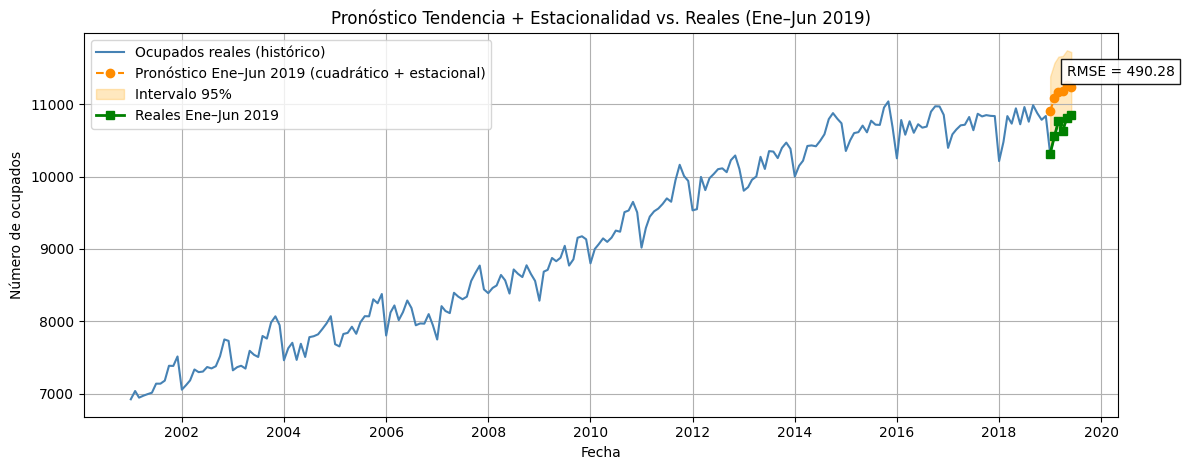

RMSE (Tendencia + Estacionalidad) Ene–Jun 2019: 490.28


In [477]:
h = 6

future_idx = pd.date_range('2019-01-01', periods=h, freq='MS')

last_t = int(data["x"].iloc[-1])
x_for = np.arange(last_t + 1, last_t + h + 1, dtype=float)
x_for_quad = pd.DataFrame({"x": x_for, "x2": x_for**2}, index=future_idx)

train_cols = month_dummies.columns
future_dummies = pd.DataFrame(0, index=future_idx, columns=train_cols, dtype=float)
for dt in future_idx:
    m = dt.month
    if m in train_cols:
        future_dummies.loc[dt, m] = 1.0

X_for = pd.concat([x_for_quad, future_dummies], axis=1)
X_for = sm.add_constant(X_for, has_constant='add')
X_for = X_for[season_pol_2.model.exog_names]            # respeta el orden del entrenamiento

sf = season_pol_2.get_prediction(X_for).summary_frame(alpha=0.05)
preds = sf[['mean', 'obs_ci_lower', 'obs_ci_upper']].rename(
    columns={'mean':'Point_forecast','obs_ci_lower':'lower_95','obs_ci_upper':'upper_95'}
)
preds.index = future_idx

y_real_6 = data.loc['2019-01':'2019-06', 'Ocupados']
y_pred_6 = preds.loc['2019-01':'2019-06', 'Point_forecast']

common = y_real_6.index.intersection(y_pred_6.index)
y_real_6 = y_real_6.loc[common]
y_pred_6 = y_pred_6.loc[common]

rmse = np.sqrt(mean_squared_error(y_real_6, y_pred_6))

plt.figure(figsize=(12,4.8))

plt.plot(data.index, data['Ocupados'], color='steelblue', label='Ocupados reales (histórico)')

plt.plot(preds.index, preds['Point_forecast'], '--o', color='darkorange',
         label='Pronóstico Ene–Jun 2019 (cuadrático + estacional)')

plt.fill_between(preds.index, preds['lower_95'], preds['upper_95'],
                 color='orange', alpha=0.25, label='Intervalo 95%')

plt.plot(y_real_6.index, y_real_6.values, 'gs-', linewidth=2, label='Reales Ene–Jun 2019')

y_top = max(data['Ocupados'].max(), preds['upper_95'].max())
plt.text(preds.index[-2], y_top*0.97, f"RMSE = {rmse:.2f}",
         fontsize=10, bbox=dict(facecolor='white', alpha=0.9))

plt.title('Pronóstico Tendencia + Estacionalidad vs. Reales (Ene–Jun 2019)')
plt.xlabel('Fecha'); plt.ylabel('Número de ocupados')
plt.legend(loc='upper left'); plt.grid(True); plt.tight_layout()
plt.show()
print(f"RMSE (Tendencia + Estacionalidad) Ene–Jun 2019: {rmse:.2f}")

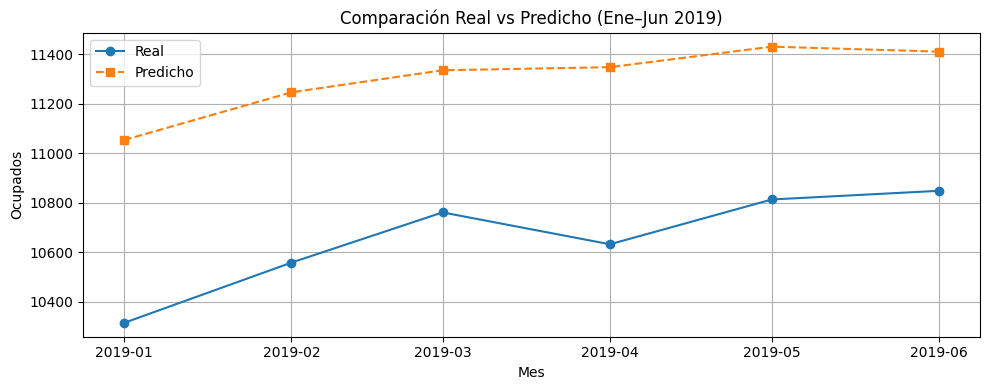

In [478]:
y = data["Ocupados"].copy()

data = data.copy()
data["t"] = np.arange(1, len(data) + 1, dtype=float)

month_dummies = pd.get_dummies(data.index.month, drop_first=True, dtype=float).set_index(data.index)

X_ts = sm.add_constant(pd.concat([data[["t"]], month_dummies], axis=1))
mod_ts = sm.OLS(y, X_ts).fit()

target_idx = pd.date_range("2019-01-01", periods=6, freq="MS")

t_last = int(data["t"].iloc[-1])
t_future = pd.Series(np.arange(t_last + 1, t_last + 6 + 1), index=target_idx, name="t")

train_cols = month_dummies.columns
future_dummies = pd.DataFrame(0, index=target_idx, columns=train_cols, dtype=float)
for dt in target_idx:
    m = dt.month
    if m in train_cols:
        future_dummies.loc[dt, m] = 1.0

X_for_ts = sm.add_constant(pd.concat([t_future, future_dummies], axis=1), has_constant="add")

X_for_ts = X_for_ts[mod_ts.model.exog_names]

pred_mean = mod_ts.get_prediction(X_for_ts).summary_frame()["mean"]
pred_mean.name = "Predicho"

y_real = data.loc[target_idx, "Ocupados"]
cmp = pd.concat([y_real.rename("Real"), pred_mean], axis=1)

plt.figure(figsize=(10,4))
plt.plot(cmp.index, cmp["Real"], marker="o", label="Real")
plt.plot(cmp.index, cmp["Predicho"], marker="s", linestyle="--", label="Predicho")
plt.title("Comparación Real vs Predicho (Ene–Jun 2019)")
plt.xlabel("Mes"); plt.ylabel("Ocupados")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

### **8. Modelo de Suavización Exponencial Holt Winters**

In [499]:
train_len_2 = 216
train_td_2 = data[["Ocupados"]][:train_len_2]
test_td_2 = data[["Ocupados"]][train_len_2:]

In [500]:
## Sin considerar el dato actual
ma_2_2= train_td_2.shift().rolling(2,min_periods=2).mean()
ma_3_2= train_td_2.shift().rolling(3,min_periods=2).mean()
ma_4_2= train_td_2.shift().rolling(4,min_periods=2).mean()
ma_5_2= train_td_2.shift().rolling(5,min_periods=2).mean()

In [501]:
def fore_ma(datos_2,w,h):
  data_2=datos_2.copy()
  for x in range(1,h+1):
    ind = data_2.index[-1]
    value = ind + pd.DateOffset(months=1)
    data_2.loc[value]= data_2[-w:].mean()
  return data_2[-h:]

In [502]:
ma_2_f_2= fore_ma(train_td_2,2,6)
ma_3_f_2= fore_ma(train_td_2,3,6)
ma_4_f_2= fore_ma(train_td_2,4,6)
ma_5_f_2= fore_ma(train_td_2,5,6)

In [503]:
ets_model = ETSModel(endog=train_td_2["Ocupados"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2019-01-01    10349.094194  10090.610132  10607.578256
2019-02-01    10624.690071  10350.551423  10898.828720
2019-03-01    10770.101783  10481.152558  11059.051007
2019-04-01    10786.274106  10483.234541  11089.313670
2019-05-01    10870.829275  10554.323400  11187.335150
2019-06-01    10828.784921  10499.360228  11158.209614


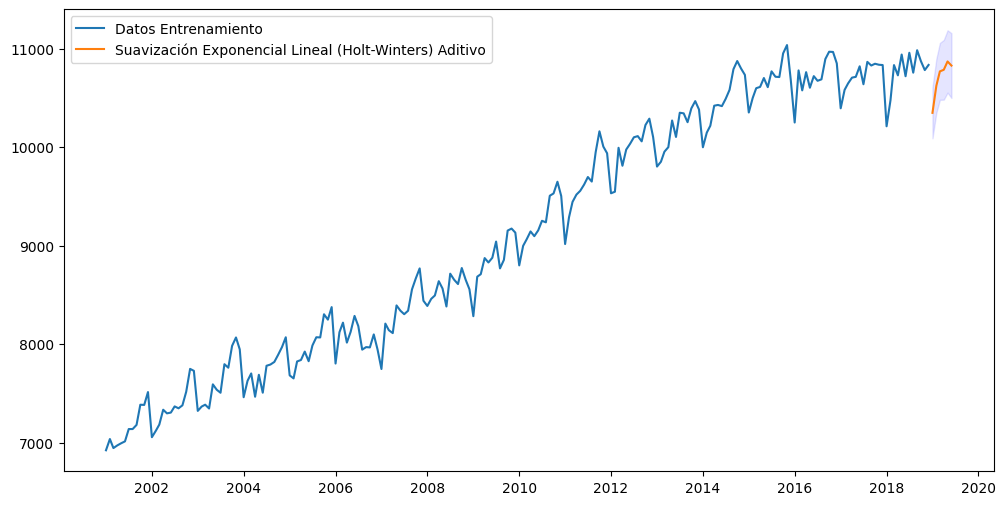

In [504]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td_2,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [505]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.35322663405671384 3.5322663405671385e-05 0.29694595046559796


In [506]:
rmse_hw_add = np.sqrt(mean_squared_error(test_td_2,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

74.44457717563775


### **9. Supuestos para el Modelo de Tendencia + Estacionalidad (RMSE = 490,28)**


Residuos Ene–Jun 2019:
 2019-01-01   -491.40
2019-02-01   -436.65
2019-03-01   -318.70
2019-04-01   -455.96
2019-05-01   -353.75
2019-06-01   -294.43
dtype: float64


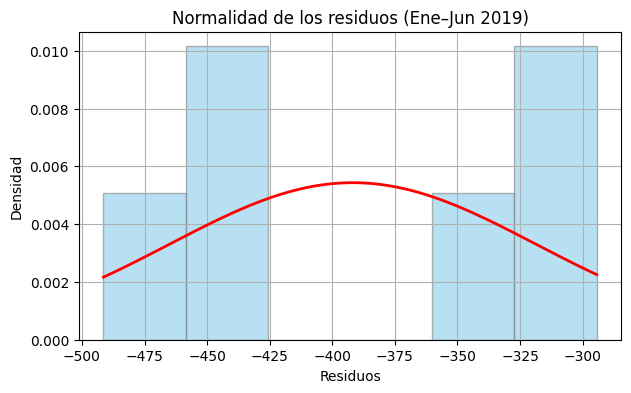

/usr/local/lib/python3.12/dist-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


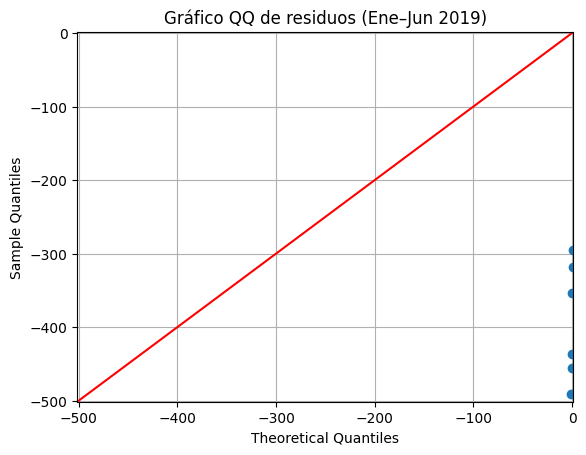


 Pruebas de normalidad:
Shapiro-Wilk: ShapiroResult(statistic=np.float64(0.9205887347758948), pvalue=np.float64(0.5096113213586582))
Jarque-Bera : SignificanceResult(statistic=np.float64(0.6577133176710906), pvalue=np.float64(0.7197461786085816))


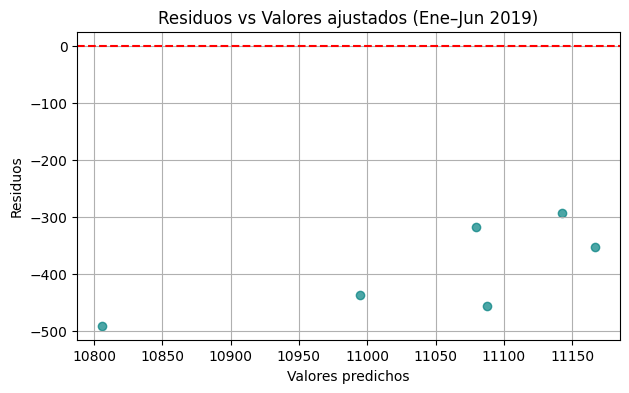


 Prueba de homocedasticidad (Breusch–Pagan):
{'LM Statistic': np.float64(6.0), 'LM p-value': np.float64(0.9461529592997832), 'F-Statistic': np.float64(nan), 'F p-value': np.float64(nan)}

 Durbin–Watson: 0.052

 Prueba de Ljung–Box:
    lb_stat  lb_pvalue
1  0.046043   0.830097
2  0.757438   0.684738
3  2.890866   0.408759

 Resumen de supuestos:
 Normalidad (Shapiro-Wilk): Se cumple (p=0.510 > 0.05)
 Homocedasticidad (Breusch–Pagan): No se cumple (p=nan ≤ 0.05)
 No autocorrelación (Ljung–Box): Se cumple (p=0.830 > 0.05)
Durbin–Watson = 0.05 (ideal ~2)


In [515]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

target_idx = pd.date_range('2019-01-01', periods=6, freq='MS')
y_real = data.loc[target_idx, "Ocupados"]
y_pred = season_pol_2.predict(X.loc[target_idx])
resid_6 = y_real - y_pred
print("\nResiduos Ene–Jun 2019:\n", resid_6.round(2))

mu, sigma = stats.norm.fit(resid_6)
x = np.linspace(min(resid_6), max(resid_6), 100)
y_norm = stats.norm.pdf(x, mu, sigma)

plt.figure(figsize=(7,4))
plt.hist(resid_6, bins=6, density=True, alpha=0.6, color='skyblue', edgecolor='gray')
plt.plot(x, y_norm, 'r', linewidth=2)
plt.title("Normalidad de los residuos (Ene–Jun 2019)")
plt.xlabel("Residuos"); plt.ylabel("Densidad"); plt.grid(True)
plt.show()

sm.qqplot(resid_6, line='45', color='navy')
plt.title("Gráfico QQ de residuos (Ene–Jun 2019)")
plt.grid(True)
plt.show()

print("\n Pruebas de normalidad:")
print("Shapiro-Wilk:", stats.shapiro(resid_6))
print("Jarque-Bera :", stats.jarque_bera(resid_6))

plt.figure(figsize=(7,4))
plt.scatter(y_pred, resid_6, color='teal', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuos vs Valores ajustados (Ene–Jun 2019)")
plt.xlabel("Valores predichos"); plt.ylabel("Residuos")
plt.grid(True)
plt.show()

print("\n Prueba de homocedasticidad (Breusch–Pagan):")
bp_test = het_breuschpagan(resid_6, X.loc[target_idx])
labels = ['LM Statistic', 'LM p-value', 'F-Statistic', 'F p-value']
print(dict(zip(labels, bp_test)))

dw = durbin_watson(resid_6)
print(f"\n Durbin–Watson: {dw:.3f}")

lb = acorr_ljungbox(resid_6, lags=[1, 2, 3], return_df=True)
print("\n Prueba de Ljung–Box:")
print(lb)

def interpret_test(name, pval, alpha=0.05):
    return f" {name}: Se cumple (p={pval:.3f} > 0.05)" if pval > alpha else f" {name}: No se cumple (p={pval:.3f} ≤ 0.05)"

_, p_sw = stats.shapiro(resid_6)
_, _, _, p_bp = het_breuschpagan(resid_6, X.loc[target_idx])
p_lb = lb['lb_pvalue'].iloc[0]

print("\n Resumen de supuestos:")
print(interpret_test("Normalidad (Shapiro-Wilk)", p_sw))
print(interpret_test("Homocedasticidad (Breusch–Pagan)", p_bp))
print(interpret_test("No autocorrelación (Ljung–Box)", p_lb))
print(f"Durbin–Watson = {dw:.2f} (ideal ~2)")
